In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from src.models.ecg_model import ECG_Model
import typing as tp
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

In [2]:
dt = 1e-4  # set time step
t = np.arange(0, 10, dt)

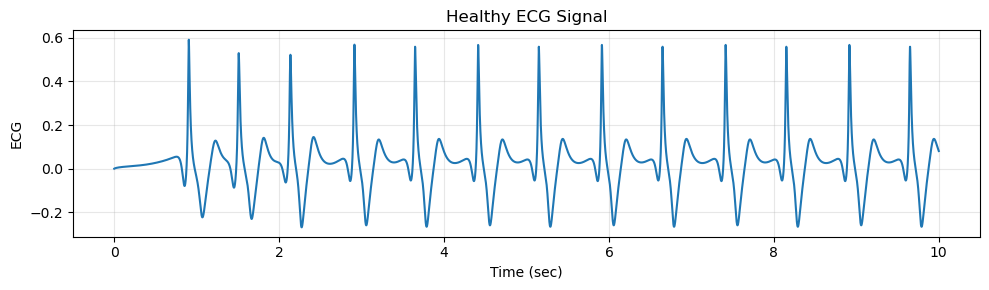

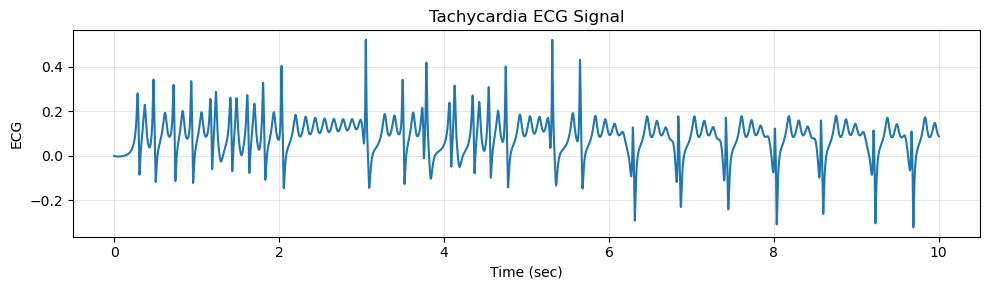

In [3]:
ecg = ECG_Model()
ECG_healthy, X_healthy = ecg.run(t, case='healthy')
ECG_tachycardia, X_tachycardia = ecg.run(t, case='tachycardia')